## Parameters

In [1]:
LAMBDA = 0.5
CENTER_LOSS_ALPHA = 0.5
NUM_CLASSES = 2
batch_size = 128


## Import modules

In [2]:
import os
import numpy as np
import tensorflow as tf
import tflearn
from tensorflow.examples.tutorials.mnist import input_data

slim = tf.contrib.slim
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/home/hope-yao/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Construct network

In [3]:
with tf.name_scope('input'):
    input_images = tf.placeholder(tf.float32, shape=(batch_size,28,28,1), name='input_images')
    labels = tf.placeholder(tf.int64, shape=(batch_size), name='labels')
    
global_step = tf.Variable(0, trainable=False, name='global_step')

In [4]:
def get_center_loss(features, labels, alpha, num_classes):
    """获取center loss及center的更新op
    
    Arguments:
        features: Tensor,表征样本特征,一般使用某个fc层的输出,shape应该为[batch_size, feature_length].
        labels: Tensor,表征样本label,非one-hot编码,shape应为[batch_size].
        alpha: 0-1之间的数字,控制样本类别中心的学习率,细节参考原文.
        num_classes: 整数,表明总共有多少个类别,网络分类输出有多少个神经元这里就取多少.
    
    Return：
        loss: Tensor,可与softmax loss相加作为总的loss进行优化.
        centers: Tensor,存储样本中心值的Tensor，仅查看样本中心存储的具体数值时有用.
        centers_update_op: op,用于更新样本中心的op，在训练时需要同时运行该op，否则样本中心不会更新
    """
    # 获取特征的维数，例如256维
    len_features = features.get_shape()[1]
    # 建立一个Variable,shape为[num_classes, len_features]，用于存储整个网络的样本中心，
    # 设置trainable=False是因为样本中心不是由梯度进行更新的
    centers = tf.get_variable('centers', [num_classes, len_features], dtype=tf.float32,
        initializer=tf.constant_initializer(0), trainable=False)
    # 将label展开为一维的，输入如果已经是一维的，则该动作其实无必要
    labels = tf.reshape(labels, [-1])
    
    # 根据样本label,获取mini-batch中每一个样本对应的中心值
    centers_batch = tf.gather(centers, labels)
    # 计算loss
    loss = tf.nn.l2_loss(features - centers_batch)
    
    # 当前mini-batch的特征值与它们对应的中心值之间的差
    diff = centers_batch - features
    
    # 获取mini-batch中同一类别样本出现的次数,了解原理请参考原文公式(4)
    unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
    appear_times = tf.gather(unique_count, unique_idx)
    appear_times = tf.reshape(appear_times, [-1, 1])
    
    diff = diff / tf.cast((1 + appear_times), tf.float32)
    diff = alpha * diff
    
    centers_update_op = tf.scatter_sub(centers, labels, diff)
    
    return loss, centers, centers_update_op

In [5]:
def separation_loss(centers):
    expanded_centers_0 = tf.expand_dims(centers,0)
    expanded_centers_1 = tf.expand_dims(centers,1)
    dist_matrix = tf.norm(expanded_centers_0 - expanded_centers_1, ord=2, axis=-1) # possiblly change to angular difference for high dimensional feature
    mat_size = dist_matrix.get_shape().as_list()
    mean_dist = tf.reduce_sum(dist_matrix) / mat_size[0] / (mat_size[1]-1)
    loss = 1 / (mean_dist + 1e-3)
    return loss

In [6]:

def inference(input_images, num_class=10, reuse=False):
    with slim.arg_scope([slim.conv2d], kernel_size=3, padding='SAME'):
        with slim.arg_scope([slim.max_pool2d], kernel_size=2):

            x = slim.conv2d(input_images, num_outputs=32, scope='conv1_1')
            x = slim.conv2d(x, num_outputs=32, scope='conv1_2')
            x = slim.max_pool2d(x, scope='pool1')

            x = slim.conv2d(x, num_outputs=64, scope='conv2_1')
            x = slim.conv2d(x, num_outputs=64, scope='conv2_2')
            x = slim.max_pool2d(x, scope='pool2')

            x = slim.conv2d(x, num_outputs=128, scope='conv3_1')
            x = slim.conv2d(x, num_outputs=128, scope='conv3_2')
            x = slim.max_pool2d(x, scope='pool3')

            x = slim.flatten(x, scope='flatten')

            feature2 = x = slim.fully_connected(x, num_outputs=32, activation_fn=None, scope='fc1')

            feature1 = x =slim.fully_connected(x, num_outputs=2, activation_fn=None, scope='fc2')

            x = tflearn.prelu(x)

            x = slim.fully_connected(x, num_outputs=num_class, activation_fn=None, scope='fc3')

    feature_list = [feature1, feature2]
    return x, feature_list

In [7]:
def build_network(input_images, labels, ratio=0.5, reuse=False):
    logits, feature_list = inference(input_images, num_class=2)
    
    with tf.name_scope('loss'):
        with tf.variable_scope('center_loss1'):
            center_loss1, centers1, centers_update_op1 = get_center_loss(feature_list[0], labels, CENTER_LOSS_ALPHA, NUM_CLASSES)
            separation_loss1 = separation_loss(centers1)
        with tf.variable_scope('center_loss2'):
            center_loss2, centers2, centers_update_op2 = get_center_loss(feature_list[1], labels, CENTER_LOSS_ALPHA, NUM_CLASSES)
            separation_loss2 = separation_loss(centers2)
        with tf.name_scope('softmax_loss'):
            softmax_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        with tf.name_scope('total_loss'):
            total_loss = softmax_loss + ratio * (center_loss1+100*separation_loss1)#(center_loss1*0.8 + center_loss2*0.2) * 4
    
    with tf.name_scope('acc'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(logits, 1), labels), tf.float32))
    
    with tf.name_scope('loss/'):
        tf.summary.scalar('CenterLoss1', center_loss1)
        tf.summary.scalar('CenterLoss2', center_loss2)
        tf.summary.scalar('SoftmaxLoss', softmax_loss)
        tf.summary.scalar('TotalLoss', total_loss)
        
    centers_update_op_list = [centers_update_op1, centers_update_op2]
    return logits, feature_list, total_loss, accuracy, centers_update_op_list

In [8]:
with tf.variable_scope("build_network", reuse=False):
    logits, feature_list, total_loss, accuracy, centers_update_op_list = build_network(input_images, labels, ratio=LAMBDA)
features = feature_list[0]
centers_update_op1 = centers_update_op_list[0]
centers_update_op2 = centers_update_op_list[1]


## Prepare data

In [9]:
mnist = input_data.read_data_sets('/tmp/mnist', reshape=False)

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


In [10]:

from tensorflow.contrib.data import Dataset, Iterator
train_image_5 = mnist.train.images[mnist.train.labels==5]
train_image_7 = mnist.train.images[mnist.train.labels==7]
train_images = np.concatenate([train_image_5, train_image_7],0)
train_labels = np.asarray( [0]*len(train_image_5) + [1]*len(train_image_7) )
train_dataset = Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(len(train_images))
train_dataset = train_dataset.batch(batch_size)
train_iterator = Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
#next_element = train_iterator.get_next()
#sess.run(train_iterator.make_initializer(train_dataset))
#print(sess.run(next_element)[1])

In [11]:

from tensorflow.contrib.data import Dataset, Iterator
test_image_5 = mnist.test.images[mnist.test.labels==5]
test_image_7 = mnist.test.images[mnist.test.labels==7]
test_images = np.concatenate([test_image_5, test_image_7],0)
test_labels = np.asarray( [0]*len(test_image_5) + [1]*len(test_image_7) )
test_dataset = Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.shuffle(len(test_images))
test_dataset = test_dataset.batch(batch_size)
test_iterator = Iterator.from_structure(test_dataset.output_types,
                                        test_dataset.output_shapes)

#next_element = test_iterator.get_next()
#sess.run(test_iterator.make_initializer(test_dataset))
#print(sess.run(next_element)[1])

In [12]:
train_image_5 = mnist.train.images[mnist.train.labels==5]
train_image_7 = mnist.train.images[mnist.train.labels==7]
train_images = np.concatenate([train_image_5, train_image_7],0)
train_labels = np.asarray( [0]*len(train_image_5) + [1]*len(train_image_7) )
from random import shuffle
idx = range(len(train_images))
shuffle(idx)
train_images = train_images[idx]
train_labels = train_labels[idx]

test_image_5 = mnist.test.images[mnist.test.labels==5]
test_image_7 = mnist.test.images[mnist.test.labels==7]
test_images = np.concatenate([test_image_5, test_image_7],0)
test_labels = np.asarray( [0]*len(test_image_5) + [1]*len(test_image_7) )
from random import shuffle
idx = range(len(test_images))
shuffle(idx)
test_images = test_images[idx]
test_labels = test_labels[idx]


## Optimizer

In [13]:
optimizer = tf.train.AdamOptimizer(0.001)

In [14]:
with tf.control_dependencies([centers_update_op1, centers_update_op2]):
    train_op = optimizer.minimize(total_loss, global_step=global_step)

## Session and Summary

In [15]:
summary_op = tf.summary.merge_all()

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(test_iterator.make_initializer(test_dataset))
sess.run(train_iterator.make_initializer(train_dataset))
writer = tf.summary.FileWriter('/tmp/mnist_log', sess.graph)

## Train

In [17]:
mean_data = 0#np.mean(mnist.train.images, axis=0)

In [18]:
step = sess.run(global_step)
for ep_i in range(10):
    train_acc = []
    train_sft_loss = []
    train_c_loss = []
    train_s_loss = []
    for jj in range(train_images.shape[0]/batch_size):
        _, summary_str, train_acc_i, sft_loss_i, c_loss_i, s_loss_i = sess.run(
            [train_op, summary_op, accuracy, softmax_loss, center_loss1, separation_loss1],
            feed_dict={
                input_images: train_images[jj*batch_size:(1+jj)*batch_size],
                labels: train_labels[jj*batch_size:(1+jj)*batch_size]
            })
        train_acc += [train_acc_i]
        train_sft_loss += [sft_loss_i]
        train_c_loss += [c_loss_i]
        train_s_loss += [s_loss_i]

    # writer.add_summary(summary_str, global_step=step)
    test_acc = []
    test_sft_loss = []
    test_c_loss = []
    test_s_loss = []
    for jj in range(test_images.shape[0]/batch_size):
        test_acc_i, sft_loss_i, c_loss_i, s_loss_i = sess.run(
            [accuracy, softmax_loss, center_loss1, separation_loss1]
            feed_dict={
                input_images: test_images[jj*batch_size:(1+jj)*batch_size],
                labels: test_labels[jj*batch_size:(1+jj)*batch_size]
            })
        test_acc += [test_acc_i]
        test_sft_loss += [sft_loss_i]
        test_c_loss += [c_loss_i]
        test_s_loss += [s_loss_i]

    print(("epoch: {}, train_acc:{:.4f}, vali_acc:{:.4f}".
          format(ep_i, np.mean(train_acc), np.mean(test_acc))))

epoch: 0, train_acc:0.5351, vali_acc:0.5354
epoch: 1, train_acc:0.5345, vali_acc:0.5354
epoch: 2, train_acc:0.6005, vali_acc:0.9693
epoch: 3, train_acc:0.9930, vali_acc:0.9984
epoch: 4, train_acc:0.9993, vali_acc:0.9990
epoch: 5, train_acc:0.9997, vali_acc:1.0000
epoch: 6, train_acc:0.9998, vali_acc:1.0000
epoch: 7, train_acc:1.0000, vali_acc:1.0000
epoch: 8, train_acc:1.0000, vali_acc:1.0000
epoch: 9, train_acc:1.0000, vali_acc:1.0000


### Visualize train_data

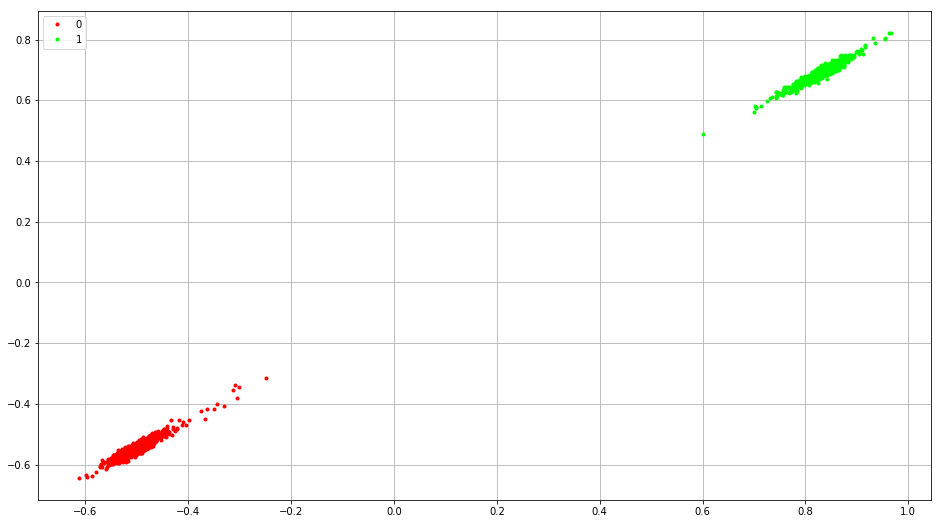

In [19]:
train_feat = []
train_pred = []
for jj in range(train_images.shape[0]/batch_size):
    [feat_i, pred_i] = sess.run([features, tf.nn.softmax(logits)], feed_dict={input_images:train_images[jj*batch_size:(1+jj)*batch_size]})
    train_feat += [feat_i]
    train_pred += [pred_i]
train_feat = np.concatenate(train_feat,0)
train_pred= np.argmax(np.concatenate(train_pred,0), 1)

%matplotlib inline
import matplotlib.pyplot as plt

labels_val = train_labels[:train_feat.shape[0]]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#00ff00', '#990000', '#00ffff', '#0000ff', 
     '#ff00ff', '#ffff00', '#999900', '#009900', '#009999']
for i in range(2):
    plt.plot(train_feat[labels_val==i,0].flatten(), train_feat[labels_val==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

miss_class = labels_val!=train_pred
for i, f_i in enumerate(miss_class):
    if f_i:
        plt.scatter(train_feat[i,0].flatten(), train_feat[i,1].flatten(), s=200, facecolors='none', edgecolors=c[train_pred[i]])

plt.grid()
plt.show()

### Visualize test_data

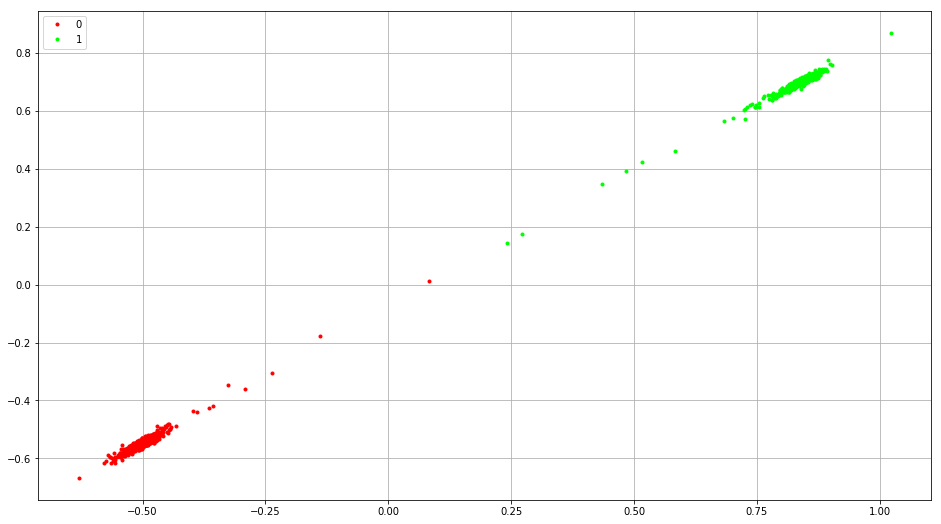

In [20]:
testing_feat = []
testing_pred = []
for jj in range(test_images.shape[0]/batch_size):
    [feat_i, pred_i] = sess.run([features, tf.nn.softmax(logits)], feed_dict={input_images: test_images[jj*batch_size:(1+jj)*batch_size]})
    testing_feat += [feat_i]
    testing_pred += [pred_i]
testing_feat = np.concatenate(testing_feat,0)
testing_pred = np.argmax( np.concatenate(testing_pred,0), 1) 

%matplotlib inline
import matplotlib.pyplot as plt

labels_val = test_labels[:testing_feat.shape[0]]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#00ff00', '#990000', '#00ffff', '#0000ff', 
     '#ff00ff', '#ffff00', '#999900', '#009900', '#009999']
for i in range(2):
    plt.plot(testing_feat[labels_val==i,0].flatten(), testing_feat[labels_val==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

miss_class = labels_val!=testing_pred
for i, f_i in enumerate(miss_class):
    if f_i:
        plt.scatter(testing_feat[i,0].flatten(), testing_feat[i,1].flatten(), s=200, facecolors='none', edgecolors=c[testing_pred[i]])

plt.grid()
plt.show()

# FGM attack

In [37]:

def get_attack_directions_lenet(input_pl_var, logits_var, label_pl, batch_xs, batch_ys, sess, epsilon=0.1):
    '''
    input_pl_var: variable of the starting placeholder of the graph, (bs, 28, 28, 1)
    output: end point of the graph, after softmax and argmax, (bs, 1)
    label_pl: placeholder of the ground truth label, used for untargeted attack, (bs, 1)
    img_val: a particular image to be attacked, (1, 28, 28, 1)
    label_val: the label associated with img_val, (1, 1)
    '''
    imsize = 28
    
#     temp = set(tf.all_variables())
    # set target
    adv_label = tf.ones_like(label_pl) - label_pl 
    # set loss
    adversarial_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=adv_label, logits=logits_var) 
    # gradient direction
    gradient_direction = tf.gradients(adversarial_loss, input_pl_var)[0]
#     # apply gradients, for iterative methods
#     optimizer = tf.train.AdamOptimizer(0.01)
#     grads = optimizer.compute_gradients(adversarial_loss, var_list=input_pl_var)
#     apply_gradient_op = optimizer.apply_gradients(grads)

#     init_op = tf.initialize_variables(set(tf.all_variables()) - temp)

    orth_transform = np.asarray([[(-1) ** j] * imsize for j in range(imsize)])
    orth_transform = np.expand_dims(np.expand_dims(orth_transform, 0), -1)
#     sess.run(init_op, feed_dict)

    feed_dict = {
                    input_pl_var: np.tile(batch_xs,(batch_size,1,1,1)),
                    label_pl: np.tile(batch_ys,(batch_size))
               }
    gradient_direction_var = sess.run(gradient_direction, feed_dict)
#     l2_norm = gradient_direction_var.reshape(batch_size,-1)
#     l2_norm = np.linalg.norm( l2_norm, ord=2, axis=1)
#     l2_norm = np.transpose(np.tile(l2_norm,(1, 1, 1, 1)),(3,0,1,2))
#     delta = gradient_direction_var / l2_norm
    delta = np.sign(gradient_direction_var)
    delta_vec = {
                    'x': delta,
                    'y': delta[:, ::-1, ::-1, :] * orth_transform
                 }

    feed_dict = {
                    input_pl_var: np.tile(batch_xs,(batch_size,1,1,1)),
                    label_pl: np.tile(batch_ys,(batch_size))
               }
    orig_prob = sess.run(tf.nn.softmax(logits_var), feed_dict)

    feed_dict = {
                    input_pl_var: np.tile(batch_xs,(batch_size,1,1,1))-delta_vec['x']*epsilon,
                    label_pl: np.tile(batch_ys,(batch_size))
               }
    adv_prob = sess.run(tf.nn.softmax(logits_var), feed_dict)
    
    return delta_vec, orig_prob, adv_prob

#     attack_history = {}
#     attack_history['x_hist'] = []
#     attack_history['y_hist'] = []
#     for i in range(50):
#         _, adversarial_img, adversarial_pred = sess.run([apply_gradient_op, input_pl_var, output_var], feed_dict)
#         attack_history['x_hist'] += [adversarial_img]
#         attack_history['y_hist'] += [adversarial_pred]

#     pred = {}
#     pred['ground_truth'] = batch_ys[0]
#     feed_dict_orig = {input_pl_var: batch_xs.reshape(1, imsize, imsize, 1)}
#     pred['original'] = sess.run(output_var, feed_dict_orig)[0]
#     feed_dict_attack = {input_pl_var: attack_history['x_hist'][-1].reshape(1, imsize, imsize, 1)}
#     pred['attacked'] = sess.run(output_var, feed_dict_attack)[0]
#     feed_dict_step = {input_pl_var: (delta_vec['x'] + batch_xs).reshape(1, imsize, imsize, 1)}
#     pred['one_large_step'] = sess.run(output_var, feed_dict_step)[0]

#     # output only when the attack is successful,
#     if np.argmax(pred['attacked']) != np.argmax(pred['original']):
#         # output only directions
#         return batch_xs, batch_ys, delta_vec, attack_history

input_pl_var = tf.Variable(input_images, name='input_pl_var')
with tf.variable_scope("build_network", reuse=True):
    logits_var, feature_list, total_loss, accuracy, centers_update_op_list = build_network(input_pl_var, labels, ratio=LAMBDA, reuse=True)


In [38]:
delta_vec_list = []
img_list = []
orig_prob_list = []
adv_prob_list = []
epsilon = 0.1
N = batch_size
attack_success_flag = []
for i in range(N):
    img_val = test_images[400+i:400+i+1]
    label_val = test_labels[400+i:400+i+1]
    delta_vec, orig_prob, adv_prob = get_attack_directions_lenet(input_pl_var, logits_var, labels, img_val, label_val, sess, epsilon=epsilon)

    delta_vec_list += [delta_vec]
    img_list += [img_val]
    orig_prob_list += [orig_prob]
    adv_prob_list += [adv_prob]
    
    if np.argmax(orig_prob[0]) != np.argmax(adv_prob[0]):
        attack_success_flag += [1]
        print('success index: {}'.format(i))
    else:
        attack_success_flag += [0]
        
tracking_img = np.concatenate(img_list,0)
tracking_grad = np.concatenate([delta_vec_list[i]['x'][0:1] for i in range(batch_size)],0)

success index: 41


label: [1]
orig pred: [0.03405175 0.9659483 ]
adv pred: [0.13186775 0.86813223]


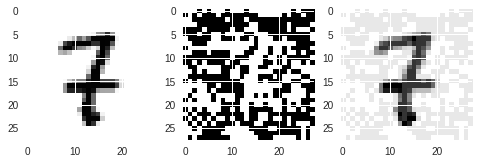

In [39]:
idx = 0
import seaborn as sns
plt.subplot(1,3,1)
plt.imshow(img_list[idx][0,:,:,0])
plt.subplot(1,3,2)
plt.imshow(-delta_vec_list[idx]['x'][0,:,:,0]*epsilon)
plt.subplot(1,3,3)
plt.imshow(img_list[idx][0,:,:,0] - delta_vec_list[idx]['x'][0,:,:,0]*epsilon)

print('label: {}'.format(label_val))
print('orig pred: {}'.format(orig_prob_list[idx][0]))
print('adv pred: {}'.format(adv_prob_list[idx][0]))

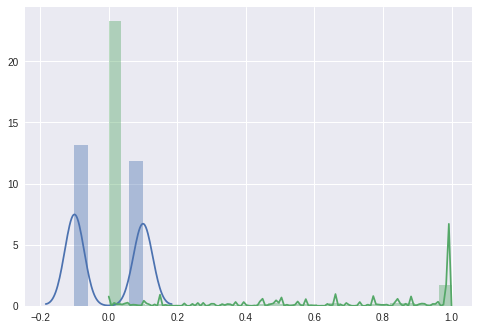

In [40]:
sns.distplot(epsilon*delta_vec_list[idx]['x'][0,:,:,0].flatten())
sns.distplot(img_list[idx][0,:,:,0].flatten())

# tracking FGM trajectories

In [41]:
tracking_feat = []
tracking_pred = []

steps = 100
largest_epsilon = 1.0
for e_i in range(steps):
    adv_img_i = tracking_img - largest_epsilon*e_i/steps * tracking_grad
    [feat_i, pred_i] = sess.run([features, tf.nn.softmax(logits)], feed_dict={input_images: adv_img_i})
    tracking_feat += [np.expand_dims(feat_i, 0)]
    tracking_pred += [np.expand_dims(pred_i, 0)]
tracking_feat = np.concatenate(tracking_feat,0).transpose(1,0,2) # (batch_size, steps, feature_dim)
tracking_pred = np.argmax( np.concatenate(tracking_pred,0), -1).transpose(1,0) # (batch_size, steps)
# save adversarial images
np.save('tracking_pred', tracking_pred)
np.save('tracking_feat', tracking_feat)

mean delta: 0.6040625
median delta: 0.335


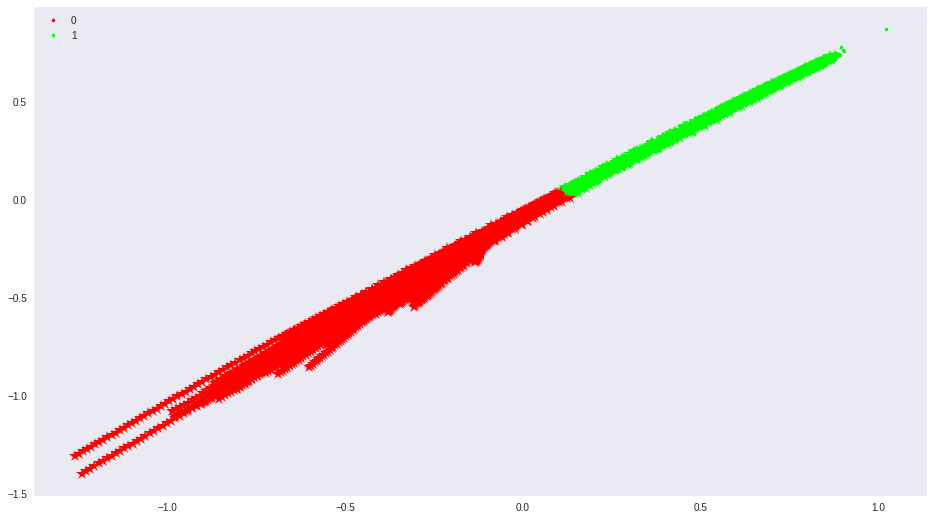

In [42]:
import matplotlib.pyplot as plt

# original testing data feature distribution
labels_val = test_labels[:testing_feat.shape[0]]
f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#00ff00', '#990000', '#00ffff', '#0000ff', 
     '#ff00ff', '#ffff00', '#999900', '#009900', '#009999']
for i in range(2):
    plt.plot(testing_feat[labels_val==i,0].flatten(), testing_feat[labels_val==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
miss_class = labels_val!=testing_pred
for i, f_i in enumerate(miss_class):
    if f_i:
        plt.scatter(testing_feat[i,0].flatten(), testing_feat[i,1].flatten(), s=200, facecolors='none', edgecolors=c[testing_pred[i]])


# adversarial data feature trajectory
N = batch_size
for i in range(N):
    if tracking_pred[i,-1] != tracking_pred[i,0]:
        plt.plot(tracking_feat[i, :, 0], tracking_feat[i, :, 1], 'k-')
mean_delta = np.zeros(N)
for i in range(N):
    if tracking_pred[i,-1] == tracking_pred[i,0]:
        mean_delta[i] += [largest_epsilon]
    else:
        for j in range(steps):
            plt.plot(tracking_feat[i, j, 0], tracking_feat[i, j, 1], '*-', MarkerSize=13, color=c[tracking_pred[i,j]])
        for j in range(steps):
            if tracking_pred[i,j] != tracking_pred[i,0]:
                mean_delta[i] += [largest_epsilon*j/steps]
                break
print('mean delta: {}'.format(np.mean(mean_delta)))
print('median delta: {}'.format(np.median(mean_delta)))
plt.grid()
plt.show()


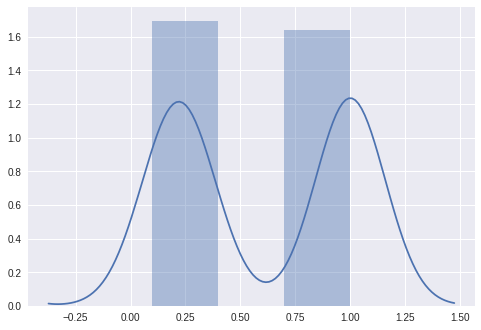

In [43]:
sns.distplot(mean_delta)

# on previous FGSM data

In [44]:
adv_img = np.load('/home/hope-yao/Documents/TensorFlow_Center_Loss/MNIST_FGSMeps0.2_and_binarized_examples.npz_FILES/FGSM_features.npy')
adv_img = np.expand_dims(adv_img, -1)

# shuffled_adv_img = []
# for img in adv_img:
#     for i in range(12):
#         for j in range(12):
#             if random.random()<0.3:
#                 patch = img[2*i:2*(i+1), 2*j:2*(j+1)] 
#                 idx = [0,1,2,3]
#                 random.shuffle(idx) 
#                 patch = patch.flatten()
#                 patch = patch[idx]
#                 patch = patch.reshape((2,2,1))
#                 img[2*i:2*(i+1), 2*j:2*(j+1)] = patch
#     shuffled_adv_img += [img]
# adv_img = np.asarray(shuffled_adv_img)

adv_label = np.load('/home/hope-yao/Documents/TensorFlow_Center_Loss/MNIST_FGSMeps0.2_and_binarized_examples.npz_FILES/orig_target.npy')
adv_label = np.argmax(adv_label,1)

feat = []
acc = []
for jj in range(adv_img.shape[0]/batch_size):
    acc_i, feat_i = sess.run([accuracy, features], feed_dict={input_images: adv_img[jj*batch_size:(1+jj)*batch_size]-mean_data,
                                                              labels: adv_label[jj*batch_size:(1+jj)*batch_size]})
    feat += [feat_i]
    acc += [acc_i]
feat = np.concatenate(feat,0)
print('adv acc: {}'.format(np.mean(acc)))

%matplotlib inline
import matplotlib.pyplot as plt
labels_val = adv_label[:feat.shape[0]]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000', '#999900', '#009900', '#009999']
for i in range(10):
    plt.plot(feat[labels_val==i,0].flatten(), feat[labels_val==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid()
plt.show()

FailedPreconditionError: Attempting to use uninitialized value input_pl_var_1
	 [[Node: input_pl_var_1/read = Identity[T=DT_FLOAT, _class=["loc:@input_pl_var_1"], _device="/job:localhost/replica:0/task:0/gpu:0"](input_pl_var_1)]]
	 [[Node: build_network/fc2/BiasAdd/_14385 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_198_build_network/fc2/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'input_pl_var_1/read', defined at:
  File "/home/hope-yao/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/hope-yao/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-1daac3991a99>", line 81, in <module>
    input_pl_var = tf.Variable(input_images, name='input_pl_var')
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/hope-yao/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value input_pl_var_1
	 [[Node: input_pl_var_1/read = Identity[T=DT_FLOAT, _class=["loc:@input_pl_var_1"], _device="/job:localhost/replica:0/task:0/gpu:0"](input_pl_var_1)]]
	 [[Node: build_network/fc2/BiasAdd/_14385 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_198_build_network/fc2/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
% matplotlib inline
import seaborn as sns
import random
img = adv_img[10,:,:,0]
plt.subplot(1,2,1)
plt.imshow(img)
for i in range(12):
    for j in range(12):
        patch = img[2*i:2*(i+1), 2*j:2*(j+1)] 
        idx = [0,1,2,3]
        random.shuffle(idx) 
        patch = patch.flatten()
        patch = patch[idx]
        patch = patch.reshape((2,2))
        img[2*i:2*(i+1), 2*j:2*(j+1)] = patch
plt.subplot(1,2,2)
plt.imshow(img)